In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Dropout, GRU, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('/content/student-data-encoded.csv')

# Separate features and target
X = data.drop(columns=['is_cleared']).values
y = data['is_cleared'].values

# One-hot encode the target
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data for Conv1D (adding one more dimension)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

In [ ]:
def denseblock(x, layers, filters, growth_rate, dropout_rate=None, weight_decay=1e-4):
    list_feature_map = [x]
    for i in range(layers):
        x = conv_factory(x, growth_rate, dropout_rate, weight_decay)
        list_feature_map.append(x)
        x = Concatenate(axis=-1)(list_feature_map)
        filters = filters + growth_rate
    return x, filters

def conv_factory(x, filters, dropout_rate=None, weight_decay=1e-4):
    x = Conv1D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.attention_dim), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.attention_dim,), initializer='random_normal', trainable=True)
        self.u = self.add_weight(shape=(self.attention_dim, 1), initializer='random_normal', trainable=True)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        output = x * tf.expand_dims(ait, -1)
        return tf.reduce_sum(output, axis=1)

# Define the input
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

# Convolutional layers with Batch Normalization
x = Conv1D(512, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x, filters = denseblock(x, layers=6, filters=32, growth_rate=16, dropout_rate=0.2)

# Bidirectional GRU
x = Bidirectional(GRU(64))(x)

# Attention Layer
x = AttentionLayer(256)(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

# Build the model
model = Model(inputs, outputs)

# Compile the model with a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 41, 1)]              0         []                            
                                                                                                  
 conv1d_78 (Conv1D)          (None, 39, 512)              2048      ['input_14[0][0]']            
                                                                                                  
 batch_normalization_47 (Ba  (None, 39, 512)              2048      ['conv1d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_79 (Conv1D)          (None, 39, 16)               24592     ['batch_normalization_47

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
   batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

Epoch 1/50
18/18 [==============================] - 13s 188ms/step - loss: 2.4361 - accuracy: 0.3321 - val_loss: 1.1686 - val_accuracy: 0.3429 - lr: 9.9982e-05
Epoch 2/50
18/18 [==============================] - 2s 128ms/step - loss: 1.5326 - accuracy: 0.3536 - val_loss: 1.1578 - val_accuracy: 0.3143 - lr: 9.9963e-05
Epoch 3/50
18/18 [==============================] - 3s 159ms/step - loss: 1.2313 - accuracy: 0.3464 - val_loss: 1.1549 - val_accuracy: 0.3143 - lr: 9.9944e-05
Epoch 4/50
18/18 [==============================] - 3s 192ms/step - loss: 1.2434 - accuracy: 0.3036 - val_loss: 1.1443 - val_accuracy: 0.3143 - lr: 9.9925e-05
Epoch 5/50
18/18 [==============================] - 2s 125ms/step - loss: 1.1391 - accuracy: 0.3643 - val_loss: 1.1364 - val_accuracy: 0.3143 - lr: 9.9906e-05
Epoch 6/50
18/18 [==============================] - 2s 126ms/step - loss: 1.1561 - accuracy: 0.3321 - val_loss: 1.1346 - val_accuracy: 0.3143 - lr: 9.9887e-05
Epoch 7/50
18/18 [===========================

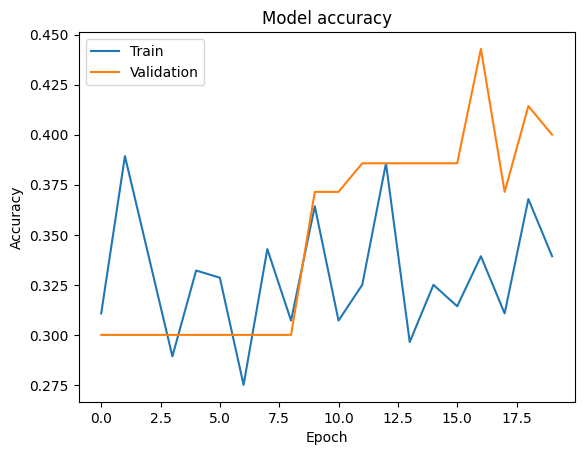

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

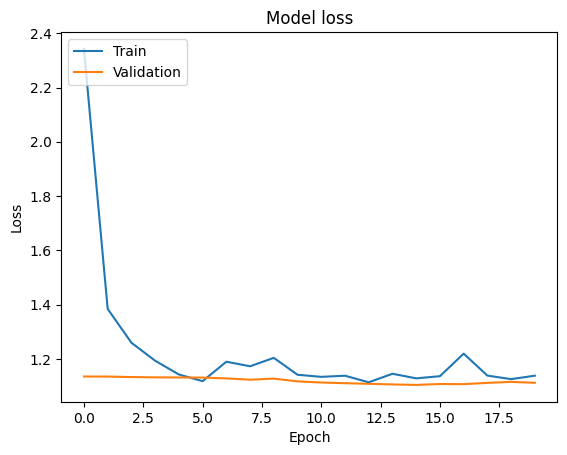

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf  # Import TensorFlow correctly
from kerastuner import RandomSearch

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))  # Input layer

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))  # Hidden layer
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout layer

    # Modified final Dense layer for multi-class classification
    model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Output layer for 3 classes

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy')  # Loss function for multi-class classification
    return model

# The rest of your code remains unchanged
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameters that gave the best validation performance are:
- Learning rate: {best_hps.get('learning_rate')}
- Units in the first Dense layer: {best_hps.get('units')}
- Dropout rate: {best_hps.get('dropout')}
""")

model = tuner.hypermodel.build(best_hps)

Reloading Tuner from my_dir/helloworld/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
224               |32                |units
0.3               |0.4               |dropout
0.01              |0.001             |learning_rate

Epoch 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filezitii0rt.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 41, 3) are incompatible

